<a href="https://colab.research.google.com/github/Nibaron/THESIS/blob/main/Twitter_Airline_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**HERE WE WILL PRACTICE CODE FOR THESIS**

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [5]:
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from textblob import TextBlob
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
import time
from keras.layers import Dense, Input, Flatten, LSTM, Bidirectional,Embedding, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential, load_model
from keras import losses
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df=pd.read_csv('/content/drive/MyDrive/THESIS/twitter-airline-sentiment/Tweets.csv')

In [8]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

***RATIO OF NEGATIVE,POSITIVE AND NEUTRAL***

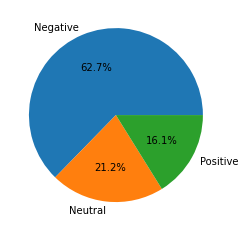

In [10]:
label=['Negative','Neutral','Positive']
plt.pie(df.groupby('airline_sentiment')['airline_sentiment'].count(),autopct="%.1f%%",labels=label)
plt.show()

***RATIO OF AIR PLANES***

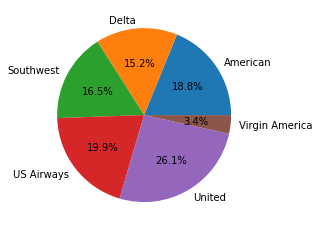

In [11]:
label=['American', 'Delta', 'Southwest', 'US Airways', 'United',
       'Virgin America']
plt.pie(df.groupby('airline')['airline_sentiment'].count(),autopct="%.1f%%",labels=label)
plt.show()

*** What is the worst negative reason ? ***

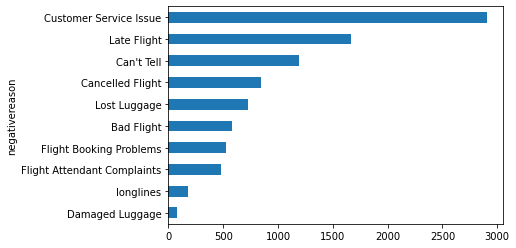

In [12]:
df.groupby('negativereason')['negativereason'].count().sort_values(ascending=True).plot.barh()

Ratio of 'Negative', 'Positive' and 'Neutral' by airplanes

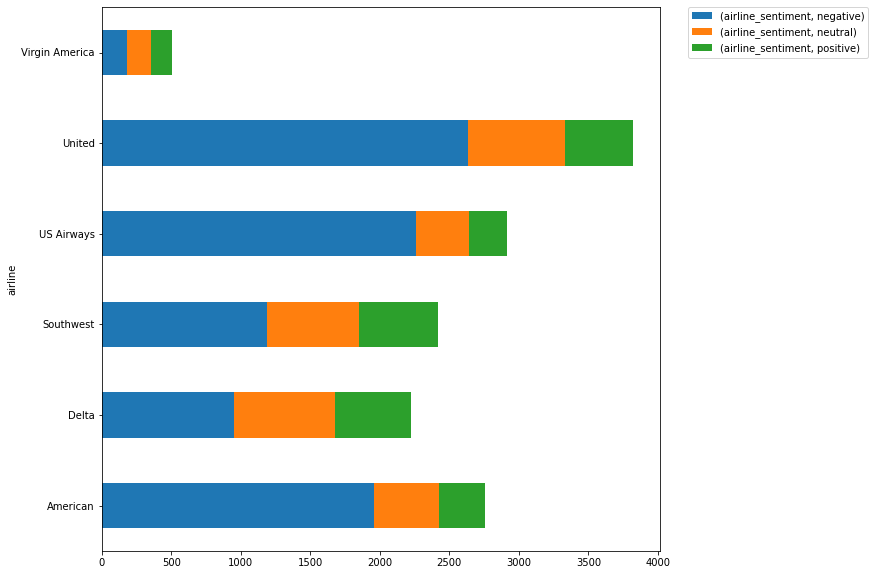

In [13]:
pd.DataFrame(df.groupby('airline')['airline_sentiment'].value_counts()).unstack().plot.barh(figsize=(10,10),stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)
plt.show()

Ratio of airplanes by 'Negative', 'Positive' and 'Neutral'

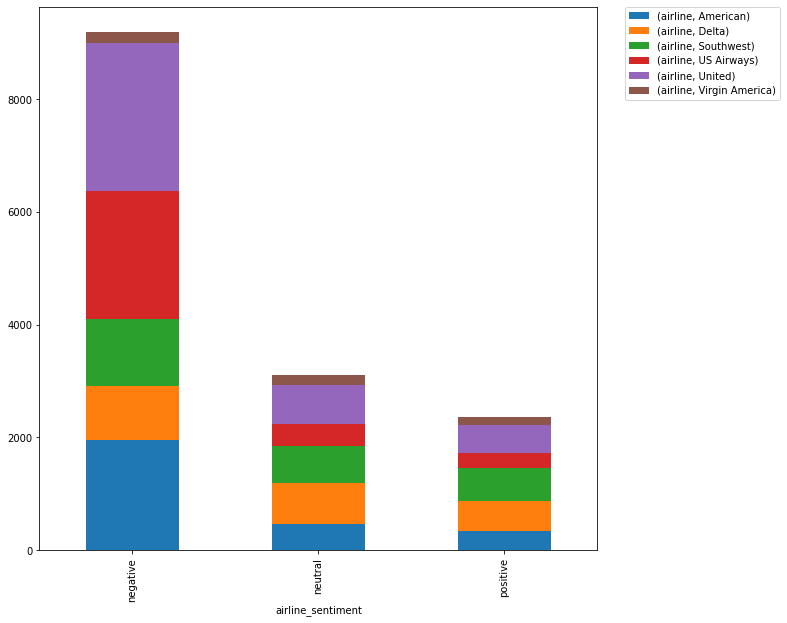

In [14]:
pd.DataFrame(df.groupby('airline_sentiment')['airline'].value_counts()).unstack().plot.bar(figsize=(10,10),stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)
plt.show()

Ratio of negative reason by airplanes

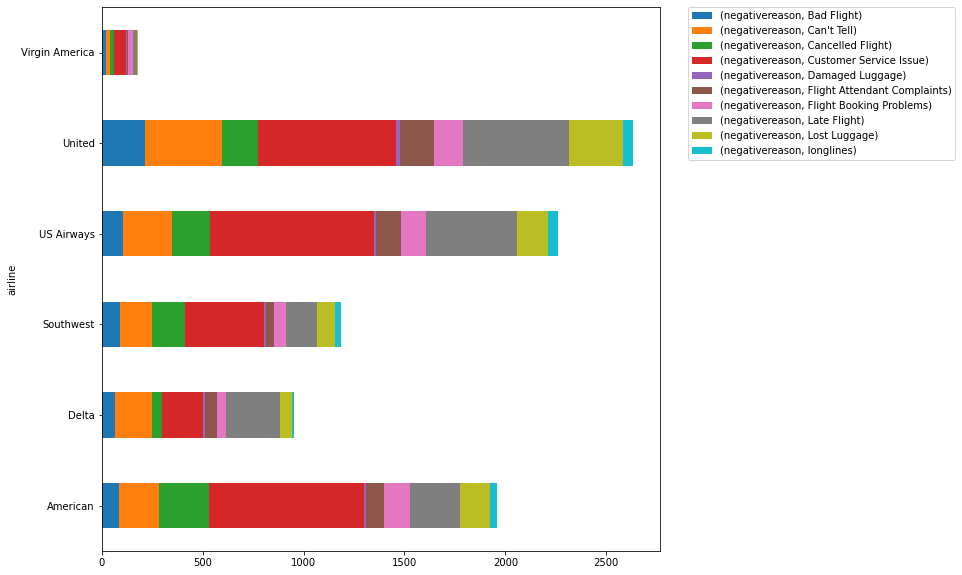

In [15]:
pd.DataFrame(df.groupby('airline')['negativereason'].value_counts()).unstack().plot.barh(figsize=(10,10),stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)
plt.show()

Ratio of airplanes by negative reason

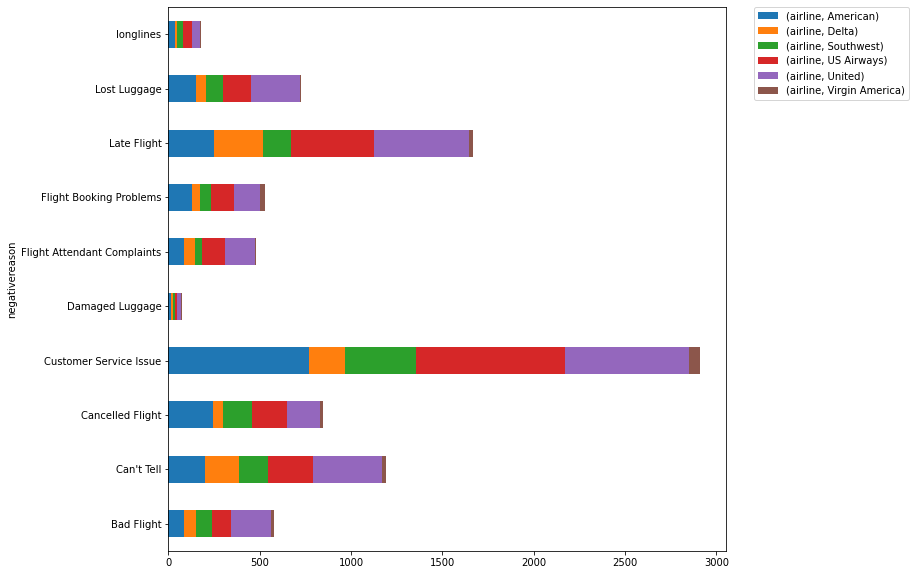

In [16]:
pd.DataFrame(df.groupby('negativereason')['airline'].value_counts()).unstack().plot.barh(figsize=(10,10),stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)
plt.show()

Kernel distribution of number of words by 'Negative', 'Positive' and 'Neutral'

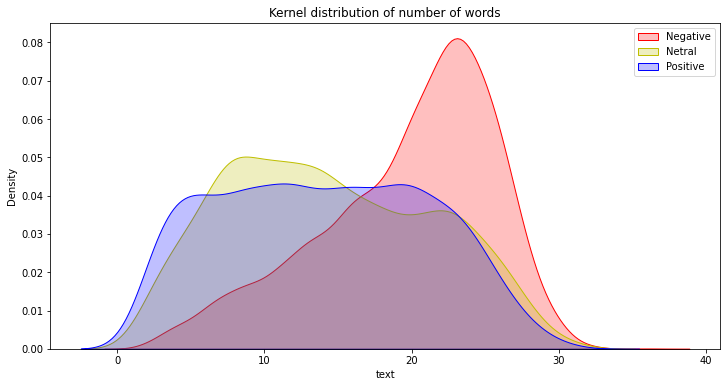

In [17]:
num_neg = df[df['airline_sentiment']=='negative']['text'].apply(lambda x: len(x.split()))
num_neu = df[df['airline_sentiment']=='neutral']['text'].apply(lambda x: len(x.split()))
num_pos = df[df['airline_sentiment']=='positive']['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12,6))
sns.kdeplot(num_neg, shade=True, color = 'r').set_title('Kernel distribution of number of words')
sns.kdeplot(num_neu, shade=True, color = 'y')
sns.kdeplot(num_pos, shade=True, color = 'b')

plt.legend(labels=['Negative', 'Netral','Positive'])

NLTK
* Tokenize

In [18]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def clean_text(d):
    pattern = r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', d)
    return text

names = ['delta', 'deltaair', 'united', 'unitedair', 'southwest', 'southwestair', 'usairways',
         'virginamerica', 'american', 'americanair', 'jetblue', 'jetblues', 'usairway',
         'flight', 'airline', 'airlines']

# In 'Twitter Sentiment Analysis - EDA and ML/DL', the name of airlines are not relevant to the sentiment analysis and added to the list of stop words.
# So I followed it.
def clean_stopword(d):
    stop_words = stopwords.words('english')
    for name in names:
        stop_words.append(name)
    return " ".join([w.lower() for w in d.split() if w.lower() not in stop_words and len(w) > 1])

def tokenize(d):
    return word_tokenize(d)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [20]:
df['final_text']= df.text.apply(clean_text).apply(clean_stopword).apply(tokenize)
df.final_text.head()

0                                     [dhepburn, said]
1    [plus, youve, added, commercials, experience, ...
2    [didnt, today, must, mean, need, take, another...
3    [really, aggressive, blast, obnoxious, enterta...
4                            [really, big, bad, thing]
Name: final_text, dtype: object

In [21]:
print(" ".join(df.final_text[0]),'\n')
print(" ".join(df.final_text[1]),'\n')
print(" ".join(df.final_text[100]),'\n')
print(" ".join(df.final_text[1000]),'\n')
print(" ".join(df.final_text[10000]))

dhepburn said 

plus youve added commercials experience tacky 

trying add boy prince ressie sf thursday lax httptcogsbjcgm 

put bag plane seattle waiting line talk someone bag status matter 

waiting day atl since cancelled flightled standby told seats group shows late gets phl


Valence Aware Dictionary and sEntiment Reasoner (VADER)
VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. VADER uses a combination of A sentiment lexicon is a list of lexical features (e.g., words) which are generally labeled according to their semantic orientation as either positive or negative. VADER not only tells about the Positivity and Negativity score but also tells us about how positive or negative a sentiment is.

reference: https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/

In [22]:
nltk.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()
vader.polarity_scores(" ".join(df.final_text[0]))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}

In [23]:
texts = [" ".join(df.final_text[i]) for i in range(len(df))]

print(df.text[0])
print(texts[0])
print(vader.polarity_scores(texts[0]), f'--> Actual Classification: {df.airline_sentiment[0]}', '\n')

print(df.text[25])
print(texts[25])
print(vader.polarity_scores(texts[25]), f'--> Actual Classification: {df.airline_sentiment[25]}', '\n')

print(df.text[575])
print(texts[575])
print(vader.polarity_scores(texts[575]), f'--> Actual Classification: {df.airline_sentiment[575]}', '\n')

print(df.text[5000])
print(texts[5000])
print(vader.polarity_scores(texts[5000]), f'--> Actual Classification: {df.airline_sentiment[5000]}', '\n')

@VirginAmerica What @dhepburn said.
dhepburn said
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} --> Actual Classification: neutral 

@VirginAmerica status match program.  I applied and it's been three weeks.  Called and emailed with no response.
status match program applied three weeks called emailed response
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} --> Actual Classification: negative 

@united in addition, my first flight was delayed an hour and I'm arriving at my destination 8 hrs Late Flight.
addition first delayed hour im arriving destination hrs late
{'neg': 0.192, 'neu': 0.808, 'pos': 0.0, 'compound': -0.2263} --> Actual Classification: negative 

@SouthwestAir - neveryamind I paid $450 for a flight. 250 for a new bag is easy for business class customers, right? http://t.co/vn3JJIa53O
neveryamind paid new bag easy business class customers right httptcovnjjiao
{'neg': 0.0, 'neu': 0.756, 'pos': 0.244, 'compound': 0.4404} --> Actual Classification: negative 



Finalize text to classify

In [24]:
df.final_text

0                                         [dhepburn, said]
1        [plus, youve, added, commercials, experience, ...
2        [didnt, today, must, mean, need, take, another...
3        [really, aggressive, blast, obnoxious, enterta...
4                                [really, big, bad, thing]
                               ...                        
14635                     [thank, got, different, chicago]
14636    [leaving, minutes, late, warnings, communicati...
14637                          [please, bring, blackberry]
14638    [money, change, dont, answer, phones, suggesti...
14639    [ppl, need, know, many, seats, next, plz, put,...
Name: final_text, Length: 14640, dtype: object

In [25]:
for i in range(len(df)):
    df['final_text'][i] = " ".join(df['final_text'][i])

In [26]:
df['final_text'][:3]

0                                    dhepburn said
1    plus youve added commercials experience tacky
2     didnt today must mean need take another trip
Name: final_text, dtype: object

In [27]:
def convert_Sentiment(sentiment):
    if  sentiment == "positive":
        return 2
    elif sentiment == "neutral":
        return 1
    elif sentiment == "negative":
        return 0
    
df.airline_sentiment = df.airline_sentiment.apply(lambda x : convert_Sentiment(x))

In [29]:
X= df.final_text
y= df.airline_sentiment

TF-IDF & Logistic Regression
* TF -IDF

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2, random_state = 4)

In [32]:
def tfidf(words):
    tfidf_vectorizer = TfidfVectorizer()
    data_feature = tfidf_vectorizer.fit_transform(words)
    return data_feature, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train.tolist())
X_test_tfidf = tfidf_vectorizer.transform(X_test.tolist())

In [33]:
X_train_tfidf.shape

(11712, 12616)

Logistic Regression

In [34]:
lr_tfidf = LogisticRegression(random_state=42,solver = 'liblinear')
lr_tfidf.fit(X_train_tfidf, y_train)
y_predicted_lr = lr_tfidf.predict(X_test_tfidf)

In [35]:
def score_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted,average= 'macro')
    recall = recall_score(y_test, y_predicted,average='macro')
    print("accuracy = %0.3f, precision = %0.3f, recall = %0.3f" % (accuracy, precision, recall))

In [36]:
score_metrics(y_test, y_predicted_lr)

accuracy = 0.777, precision = 0.774, recall = 0.640


In [37]:
def plot_confusion_matrix(y_test, y_predicted, title='Confusion Matrix'):
    cm = confusion_matrix(y_test, y_predicted)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm,annot=True, fmt='.20g')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

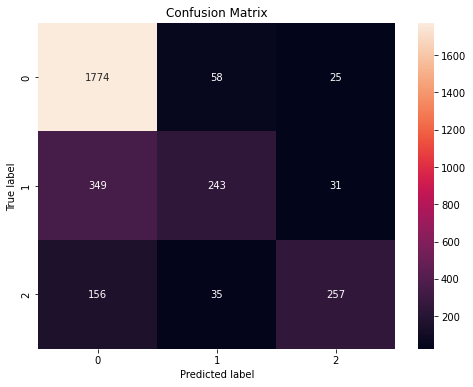

In [38]:
plot_confusion_matrix(y_test, y_predicted_lr)

Word2Vec

image7-1.jpeg
In Word2Vec, there are two types. One is Continuous Bag-of-Words Model (CBOW) , and the other is Continuous Skip-gram Model.In Skip-Gram, we try to predict the context words using the main word.In Continuous Bag of Words, the algorithm is really similar, but doing the opposite operation. From the context words, we want our model to predict the main word.

reference: https://www.baeldung.com/cs/word-embeddings-cbow-vs-skip-gram

In [39]:
texts_w2v = df.final_text.apply(tokenize).to_list()

w2v = Word2Vec(sentences = texts_w2v, window = 3, min_count = 5, workers = 4, sg = 1)

In [40]:
alert code change    /* texts_w2v = df.final_text.apply(tokenize).to_list()

w2v = Word2Vec(sentences = texts_w2v, window = 3,
               vector_size = 100, min_count = 5, workers = 4, sg = 1) */

SyntaxError: ignored

In [41]:
texts_w2v[:3]

[['dhepburn', 'said'],
 ['plus', 'youve', 'added', 'commercials', 'experience', 'tacky'],
 ['didnt', 'today', 'must', 'mean', 'need', 'take', 'another', 'trip']]

In [42]:
w2v.wv.doesnt_match("man woman dog child kitchen".split())

'child'

In [43]:
w2v.wv.doesnt_match("comfortable bad good well".split())

'bad'

In [44]:
w2v.wv.most_similar('thank')

[('much', 0.9832874536514282),
 ('appreciate', 0.978935718536377),
 ('amazing', 0.9704297780990601),
 ('care', 0.9592820405960083),
 ('best', 0.9583812952041626),
 ('awesome', 0.9557574987411499),
 ('company', 0.9548006057739258),
 ('thanks', 0.9541154503822327),
 ('love', 0.9537826776504517),
 ('twitter', 0.9497969150543213)]

In [45]:
w2v.wv.most_similar('bad')

[('disappointed', 0.9662600755691528),
 ('lack', 0.958467960357666),
 ('awful', 0.943149983882904),
 ('experienced', 0.9428743720054626),
 ('staff', 0.9413474202156067),
 ('poor', 0.9395927786827087),
 ('flown', 0.9369202852249146),
 ('seen', 0.9361007213592529),
 ('excellent', 0.9330252408981323),
 ('terrible', 0.9314473867416382)]

In [46]:
w2v.wv.most_similar('service')

[('poor', 0.8985153436660767),
 ('relations', 0.8866140842437744),
 ('terrible', 0.8800008296966553),
 ('rep', 0.8758019208908081),
 ('worst', 0.8703840970993042),
 ('experience', 0.8688026666641235),
 ('horrible', 0.8587722778320312),
 ('rude', 0.8503153324127197),
 ('ever', 0.8374872207641602),
 ('experienced', 0.8276994824409485)]

In [47]:
w2v.wv.most_similar('delay')

[('delayed', 0.9646986722946167),
 ('runway', 0.9521734714508057),
 ('tarmac', 0.9505179524421692),
 ('stuck', 0.9497835636138916),
 ('jfk', 0.9454899430274963),
 ('half', 0.9427403211593628),
 ('sat', 0.9426022171974182),
 ('ua', 0.9414853453636169),
 ('sitting', 0.9396677017211914),
 ('ago', 0.929999828338623)]

In [48]:
w2v.wv.most_similar('luggage')

[('arrived', 0.971377968788147),
 ('bags', 0.9669680595397949),
 ('baggage', 0.9664496183395386),
 ('checked', 0.9658824801445007),
 ('sit', 0.962864339351654),
 ('boarded', 0.9625049829483032),
 ('loaded', 0.9619526863098145),
 ('pilot', 0.9588346481323242),
 ('ord', 0.9583019614219666),
 ('left', 0.9582532048225403)]

alert code change
if word in w2v.wv.index_to_key:

In [49]:
def get_avg_vector(sent):
    vector = np.zeros(100)
    total_words = 0
    for word in sent.split():        
        if word in w2v.wv:
            vector += w2v.wv.word_vec(word)
            total_words += 1
    if total_words > 0:
        return vector / total_words
    else:
        return vector
    
df['w2v_vector'] = df['text'].map(get_avg_vector)
df[['text', 'w2v_vector']].head(2)

,text,w2v_vector
0,@VirginAmerica What @dhepburn said.,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,@VirginAmerica plus you've added commercials t...,"[0.029788600280880928, -0.04928203672170639, -..."


In [50]:
word2vec_X = df['w2v_vector']
y = df['airline_sentiment']

X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(word2vec_X, y,
                                                   test_size = 0.2, random_state = 4)

In [51]:
word2vec_lr = LogisticRegression(random_state=42,solver = 'liblinear')
word2vec_lr.fit(np.stack(X_train_word2vec), y_train_word2vec)
y_predicted_word2vec_lr = word2vec_lr.predict(np.stack(X_test_word2vec))

In [52]:
score_metrics(y_test, y_predicted_word2vec_lr)

accuracy = 0.688, precision = 0.666, recall = 0.458


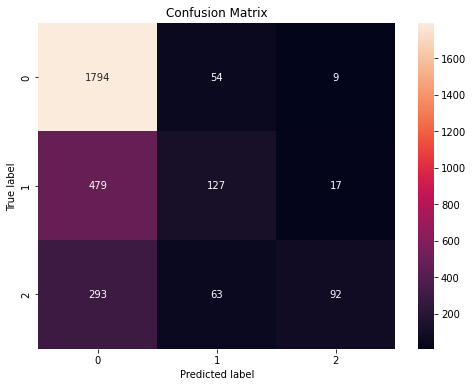

In [53]:
plot_confusion_matrix(y_test, y_predicted_word2vec_lr)

Vectors & Word Embeddings: TF-IDF vs Word2Vec

TF-IDF can be used to vectorize text into a format more agreeable for ML & NLP techniques. However while it is a popular NLP algorithm it is not the only one out there.

Word2Vec is an algorithm that uses shallow 2-layer, not deep, neural networks to ingest a corpus and produce sets of vectors. Some key differences between TF-IDF and word2vec is that TF-IDF is a statistical measure that we can apply to terms in a document and then use that to form a vector whereas word2vec will produce a vector for a term and then more work may need to be done to convert that set of vectors into a singular vector or other format. Additionally TF-IDF does not take into consideration the context of the words in the corpus whereas word2vec does.

reference:https://www.capitalone.com/tech/machine-learning/understanding-tf-idf/

In [54]:
max_words = 5000
max_len = 100

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['text'][0],'\n')
X, tokenizer = tokenize_pad_sequences(df['text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 @VirginAmerica What @dhepburn said. 

After Tokenization & Padding 
 [ 81  62 226   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [55]:
y = pd.get_dummies(df.airline_sentiment)
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, test_size=0.3, random_state=42, stratify=y_trn)

print('Train:         ', X_trn.shape, y_trn.shape)
print('Validation Set:', X_vld.shape, y_vld.shape)
print('Test Set:      ', X_tst.shape, y_tst.shape)

Train:          (8198, 100) (8198, 3)
Validation Set: (3514, 100) (3514, 3)
Test Set:       (2928, 100) (2928, 3)


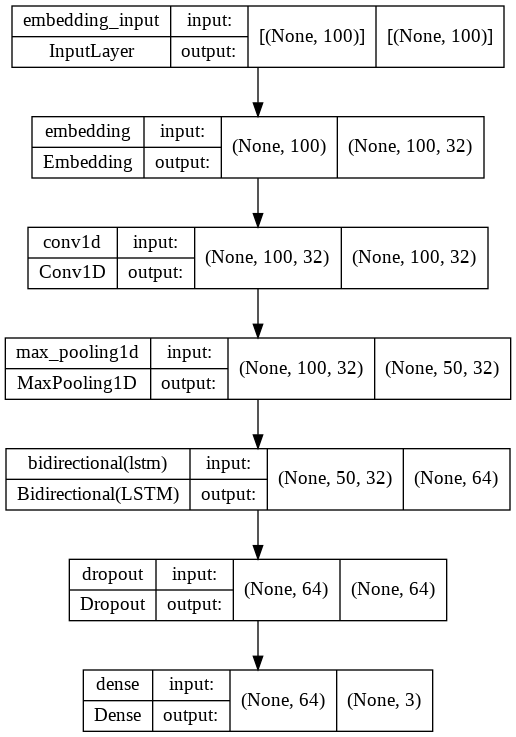

In [56]:
vocab_size = 5000
embedding_size = 32
epochs=50

model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

plot_model(model, show_shapes = True)

In [57]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           160000    
                                                                 
 conv1d (Conv1D)             (None, 100, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 32)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 1

In [69]:
es = EarlyStopping(monitor = 'val_loss', patience=5)
batch_size = 64

history = model.fit(X_trn, y_trn,
                    validation_data=(X_vld, y_vld),
                    batch_size=batch_size, epochs=epochs, verbose=1,
                    callbacks = [es])

Epoch 1/50
129/129 [==============================] - 8s 64ms/step - loss: 0.0136 - accuracy: 0.9961 - val_loss: 1.8030 - val_accuracy: 0.7641
Epoch 2/50
129/129 [==============================] - 8s 65ms/step - loss: 0.0130 - accuracy: 0.9957 - val_loss: 1.8832 - val_accuracy: 0.7658
Epoch 3/50
129/129 [==============================] - 8s 65ms/step - loss: 0.0137 - accuracy: 0.9954 - val_loss: 1.8939 - val_accuracy: 0.7595
Epoch 4/50
129/129 [==============================] - 9s 66ms/step - loss: 0.0143 - accuracy: 0.9955 - val_loss: 1.9231 - val_accuracy: 0.7618
Epoch 5/50
129/129 [==============================] - 9s 66ms/step - loss: 0.0131 - accuracy: 0.9959 - val_loss: 1.9626 - val_accuracy: 0.7575
Epoch 6/50
129/129 [==============================] - 9s 66ms/step - loss: 0.0134 - accuracy: 0.9961 - val_loss: 1.9658 - val_accuracy: 0.7698


In [66]:
loss, accuracy = model.evaluate(X_tst, y_tst, verbose=0)

# Print metrics
print('Accuracy  : {:.4f}'.format(accuracy))

Accuracy  : 0.7589


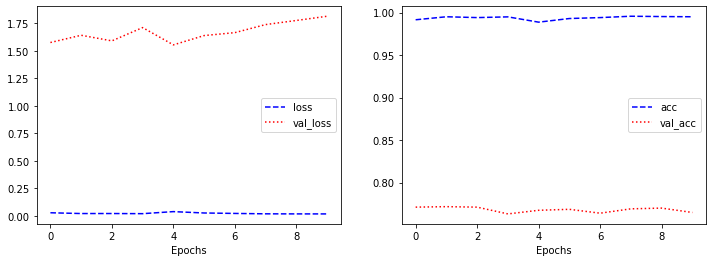

In [67]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b--', label = 'loss')
plt.plot(history.history['val_loss'], 'r:', label = 'val_loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b--', label = 'acc')
plt.plot(history.history['val_accuracy'], 'r:', label = 'val_acc')
plt.xlabel('Epochs')
plt.legend()

plt.show()

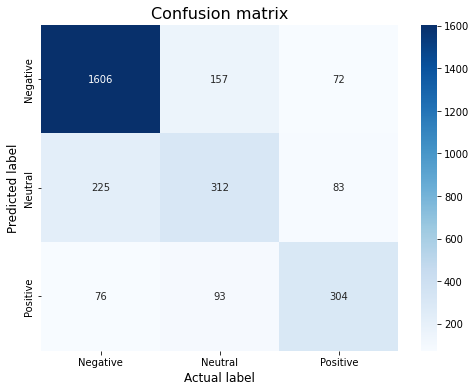

In [68]:
def plot_confusion_matrix(model, X_test, y_test):
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    y_pred = model.predict(X_test)
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_tst, y_tst)